# Instructions for getting dataframe from RDS

```
get_batch_data(
    base_coin='ETH',
    quote_coin='BTC',
    start_time='2021-01-01',                  #YYYY-MM-DD
    end_time='2021-07-01',                    #YYYY-MM-DD
    columns=['close','close_30','close_100'], # any valid features with `_x` suffix support
    batch_size=1000000,                       # Large number to get everything
    extra_rows=10,                            # Fetch extra rows for custom feature engineering
    use_cache=False,                          # Cache can be used when current time > end_time
)

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]
```

# Instructions for Manual Simulation

1. Decide on a name for your model.  Add first letter of your name and numbers as prefix  For example: `t0_dummy`.
2. Create a `.py` file with the name of your model in the `trade_models` directory (`./trade_models/t0_dummy.py`)
3. Import your model in `./trade_models/__init__.py` by adding `from . import t0_dummy`
4. Place any pre-trained models or scalers into the `./trade_models/assets/` directory with your model name as prefix.
5. Configure portfolio in the following cells.
    1. For `max_batch_size`, it is purely for memory considerations.  It does an SQL query per batch, so don't make it too small.
    2. Parameters inside portfolios are accessible inside the trade models
6. Run all

Sample portfolio (all fields must exist)
```
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy no fees',
        'trade_model' : 't0_dummy',      # name of the model to use
        'starting_coin' : 'ETH',         # aka the "base" coin
        'pair_coin' : 'BTC',             # aka the "quote" coin
        'max_batch_size' : 10000,        # how many entries to process per batch
        'starting_funds' : 16,           # amount of funds for starting coin
        'trading_fees_percent' : 0.1,    # trading fees in percent (0.1%)
        'trading_fees_buy' : 0.005,      # (0.005 ETH transaction fee to buy BTC)
        'trading_fees_sell' : 0.0004,    # (0.0004 BTC transaction fee to sell back to ETC)

        # Optional model specific parameteres
        'parameter_sample' : 'test',     # these variables are accessible in your model
    }
```

In [1]:
start_simulation = '2018-01-01' #YYYY-MM-DD
end_simulation = '2021-07-01' #YYYY-MM-DD

portfolios = [
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy no fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 20000,
        'extra_rows' : 2,
        'starting_funds' : 16,
        'trading_fees_percent' : 0.0,
        'trading_fees_buy' : 0.0,
        'trading_fees_sell' : 0.0,

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy bitflyer fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 20000,
        'extra_rows' : 2,
        'starting_funds' : 16,
        'trading_fees_percent' : 0.0,
        'trading_fees_buy' : 0.005,
        'trading_fees_sell' : 0.0004,

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy 0.1% fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 20000,
        'extra_rows' : 2,
        'starting_funds' : 16,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0.0,
        'trading_fees_sell' : 0.0,

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'BTC <-> ETH t0_dummy no fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 20000,
        'extra_rows' : 2,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.0,
        'trading_fees_buy' : 0.0,
        'trading_fees_sell' : 0.0,

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'BTC <-> ETH t0_dummy bitflyer fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 20000,
        'extra_rows' : 2,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.0,
        'trading_fees_buy' : 0.0004,
        'trading_fees_sell' : 0.005,

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
    {
        # Common parameters
        'portfolio_name' : f'BTC <-> ETH t0_dummy 0.1% fees',
        'trade_model' : 't0_dummy',
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 20000,
        'extra_rows' : 2,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0.0,
        'trading_fees_sell' : 0.0,

        # Model specific parameteres
        'parameter_sample' : 'test',
    },
]

# STOP

You shouldn't need to modify anything below this cell

# CODE FOR SIMULATION STARTS

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re
from datetime import datetime
import pytz
import re
from operator import itemgetter

# models
import trade_models

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]

In [3]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [4]:
# validate inputs and portfolio parameters

def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate fees
    assert p['trading_fees_percent'] >= 0, "Trading Fees % for must be >= 0%"
    assert p['trading_fees_percent'] < 100, "Trading Fees % for must be < 100%"
    assert p['trading_fees_buy'] >= 0, "Trading Fees (buy) for must be >= 0"
    assert p['trading_fees_sell'] >= 0, "Trading Fees (sell) for must be >= 0"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # maybe we should validate model names too!
    # TODO: validate model names

In [5]:
# These are only used for caching
import hashlib
import pickle

def get_batch_data(base_coin, quote_coin, start_time, end_time, columns, batch_size=10000, extra_rows=0, use_cache=True):
    column_info = [(x,) + re.match('^(?P<feature>[a-z][a-z0-9]*(?:_[a-z][a-z0-9]*)*)(?:_(?P<shift>[0-9]{1,3}))?$',x).groups() for x in columns]
    max_lookback = max([(0 if x==None else int(x)) for _,_,x in column_info])
    s = base_coin+quote_coin+f"{start_time}"+f"{end_time}"+"".join(columns)+str(batch_size)+str(extra_rows)
    h = hashlib.md5(s.encode('utf-8')).hexdigest()
    should_use_cache = use_cache and (datetime.strptime(end_time, '%Y-%m-%d') < datetime.now(pytz.timezone('UTC')).replace(tzinfo=None))
    if should_use_cache:
        # Can use cache
        try:
            with open(f'./cache_data/{h}.pkl', 'rb') as fp:
                print(f"Using cache file: ./cache_data/{h}.pkl")
                return pickle.load(fp)
        except:
            print(f"No cache found")
            pass

    sql = f"""
select
    f.*, open_time, open, high, low, close, volume, close_time, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume	
from
    (
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time < '{start_time}' order by open_time desc limit {max_lookback + extra_rows})
            union all
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time between '{start_time}' and '{end_time}' order by open_time limit {batch_size})
    ) cm
inner join 
    features f on f.pair_id = cm.pair_id and f.candle_open_time = cm.open_time
order by
    open_time desc
"""
    base_df = pd.read_sql_query(sql, conn)
    df = base_df[['candle_open_time']].copy()
    for name, feature, shift in column_info:
        assert feature in VALID_FEATURES, f"Invalid feature: {feature} for {name}"
        df[name] = base_df[feature].shift((0 if shift==None else -int(shift)))
        
    if extra_rows == 0:
        extra_df = None
    else:
        extra_df = df.copy()
        extra_df['is_extra'] = ~extra_df['candle_open_time'].between(start_time, end_time)
        extra_df = extra_df.set_index('candle_open_time').sort_index()
        
    df = df[df['candle_open_time'].between(start_time, end_time)]
    df = df.set_index('candle_open_time').sort_index()

    ref_df = base_df[['open_time','open', 'high', 'low', 'close']].copy()
    ref_df = ref_df[ref_df['open_time'].between(start_time, end_time)]
    ref_df = ref_df.set_index('open_time').sort_index()

    batch_close_time = base_df['close_time'].max()
    
    if should_use_cache:
        with open(f'./cache_data/{h}.pkl', 'wb') as fp:
            print(f"Saving cache to: ./cache_data/{h}.pkl")
            pickle.dump((df, ref_df, extra_df, batch_close_time), fp, protocol=4)

    return df, ref_df, extra_df, batch_close_time

In [6]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    trade_model = portfolio['trade_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    extra_rows = portfolio['extra_rows']
    starting_funds = portfolio['starting_funds']
    fee_multiplier = 1.0 - portfolio['trading_fees_percent'] / 100
    trading_fees_buy = portfolio['trading_fees_buy']
    trading_fees_sell = portfolio['trading_fees_sell']
    
    model = trade_models.__dict__[trade_model]
    columns = model.columns()

    current_time = start_time
    all_output = []
    
    info_dict = {'portfolio':portfolio}

    while True:
        # this batch data should also include feature engineering
        print("next batch: ", current_time, end=": ")
        batch_data, ref_data, extra_data, batch_close_time = get_batch_data(starting_coin, pair_coin, current_time, end_time, columns, max_batch_size, extra_rows, True)
        if len(batch_data) == 0:
            break

        batch_model_decision = model.make_decision(batch_data[columns], extra_data, info_dict)

        ref_data['trade_decision'] = batch_model_decision

        all_output.append(ref_data)
        current_time = batch_close_time

    results = pd.concat(all_output)
    
    results[['fund1','fund2','action']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    print("...Simulating actions...")
    
    for x,r in results.iterrows():
        if cur_funds[0] > 0:
            if r['trade_decision'] == 1:
                cur_funds[1] = ((cur_funds[0]-trading_fees_buy) * r['close']) * fee_multiplier
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'buy'
        else:
            if r['trade_decision'] == -1:
                cur_funds[0] = ((cur_funds[1]-trading_fees_sell) / r['open']) * fee_multiplier
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'sell'
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['action'] = results['action'].fillna('none')
    return portfolio_name, results

# START OF SIMULATION

In [7]:
simulation_results = {}

for p in portfolios:
    print(f"\"{p['portfolio_name']}\"")
    %time name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res
    print(f"Final value: {res.iloc[-1,-1]}\n\n")

"ETH <-> BTC t0_dummy no fees"
next batch:  2018-01-01: Using cache file: ./cache_data/a10544186a756566a6490cb320058381.pkl
next batch:  2018-07-30 04:44:59.999000: Using cache file: ./cache_data/7b38934f57e8f262b9f02b5af67fbecc.pkl
next batch:  2019-02-23 23:14:59.999000: Using cache file: ./cache_data/b8b9f427e8c880731e9883534e4393c7.pkl
next batch:  2019-09-21 08:14:59.999000: Using cache file: ./cache_data/59d14bc8c95ffc5eeaa268f1e582fd33.pkl
next batch:  2020-04-17 05:14:59.999000: Using cache file: ./cache_data/b1639ccd904671147e8a4e50842b31ce.pkl
next batch:  2020-11-11 19:14:59.999000: Using cache file: ./cache_data/163fa3cd29f9fa5183c2908275255617.pkl
next batch:  2021-06-08 18:44:59.999000: Using cache file: ./cache_data/edb649d6314b7c0e8c4112766bed2e58.pkl
next batch:  2021-07-01 00:14:59: Using cache file: ./cache_data/d6b21808b8ac993cdee5199b6b4ac79c.pkl
...Simulating actions...
CPU times: user 15.8 s, sys: 178 ms, total: 16 s
Wall time: 16.6 s
Final value: 663.90331013522

# END OF SIMULATION

In [8]:
for k,v in simulation_results.items():
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['action']!='none'])
    display(v['action'].value_counts())

ETH <-> BTC t0_dummy no fees
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-02 02:45:00,0.063672,0.063971,0.063005,0.063456,1,0.000000,1.015296,buy,16.000000
2018-01-02 03:15:00,0.062165,0.063387,0.062080,0.063139,-1,16.332277,0.000000,sell,16.332277
2018-01-02 03:45:00,0.063080,0.063150,0.061932,0.061941,1,0.000000,1.011638,buy,16.332277
2018-01-02 04:00:00,0.062041,0.062923,0.061932,0.062839,-1,16.305952,0.000000,sell,16.305952
2018-01-02 05:30:00,0.064397,0.064397,0.063869,0.064056,1,0.000000,1.044494,buy,16.305952
...,...,...,...,...,...,...,...,...,...
2021-06-23 00:30:00,0.057200,0.057332,0.057000,0.057183,-1,663.973143,0.000000,sell,663.973143
2021-06-25 22:45:00,0.057860,0.057908,0.057295,0.057351,1,0.000000,38.079524,buy,663.973143
2021-06-25 23:00:00,0.057359,0.057642,0.057336,0.057483,-1,663.880537,0.000000,sell,663.880537


none    119272
buy       1431
sell      1431
Name: action, dtype: int64

ETH <-> BTC t0_dummy bitflyer fees
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-02 02:45:00,0.063672,0.063971,0.063005,0.063456,1,0.000000,1.014979,buy,15.995000
2018-01-02 03:15:00,0.062165,0.063387,0.062080,0.063139,-1,16.320739,0.000000,sell,16.320739
2018-01-02 03:45:00,0.063080,0.063150,0.061932,0.061941,1,0.000000,1.010613,buy,16.315739
2018-01-02 04:00:00,0.062041,0.062923,0.061932,0.062839,-1,16.282993,0.000000,sell,16.282993
2018-01-02 05:30:00,0.064397,0.064397,0.063869,0.064056,1,0.000000,1.042703,buy,16.277993
...,...,...,...,...,...,...,...,...,...
2021-06-23 00:30:00,0.057200,0.057332,0.057000,0.057183,-1,507.898311,0.000000,sell,507.898311
2021-06-25 22:45:00,0.057860,0.057908,0.057295,0.057351,1,0.000000,29.128189,buy,507.893311
2021-06-25 23:00:00,0.057359,0.057642,0.057336,0.057483,-1,507.815500,0.000000,sell,507.815500


none    119272
buy       1431
sell      1431
Name: action, dtype: int64

ETH <-> BTC t0_dummy 0.1% fees
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-02 02:45:00,0.063672,0.063971,0.063005,0.063456,1,0.000000,1.014281,buy,15.984000
2018-01-02 03:15:00,0.062165,0.063387,0.062080,0.063139,-1,16.299629,0.000000,sell,16.299629
2018-01-02 03:45:00,0.063080,0.063150,0.061932,0.061941,1,0.000000,1.008606,buy,16.283329
2018-01-02 04:00:00,0.062041,0.062923,0.061932,0.062839,-1,16.240826,0.000000,sell,16.240826
2018-01-02 05:30:00,0.064397,0.064397,0.063869,0.064056,1,0.000000,1.039282,buy,16.224585
...,...,...,...,...,...,...,...,...,...
2021-06-23 00:30:00,0.057200,0.057332,0.057000,0.057183,-1,38.046601,0.000000,sell,38.046601
2021-06-25 22:45:00,0.057860,0.057908,0.057295,0.057351,1,0.000000,2.179829,buy,38.008554
2021-06-25 23:00:00,0.057359,0.057642,0.057336,0.057483,-1,37.965250,0.000000,sell,37.965250


none    119272
buy       1431
sell      1431
Name: action, dtype: int64

BTC <-> ETH t0_dummy no fees
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-01 01:45:00,18.496939,18.496939,18.352328,18.354349,1,0.000000,18.354349,buy,1.000000
2018-01-01 02:00:00,18.381339,18.516461,18.355360,18.429443,-1,0.998532,0.000000,sell,0.998532
2018-01-02 00:45:00,17.705069,17.724840,17.482517,17.505470,1,0.000000,17.479766,buy,0.998532
2018-01-02 02:30:00,15.318862,16.051364,15.267176,15.705491,-1,1.141062,0.000000,sell,1.141062
2018-01-02 03:30:00,15.838072,15.875284,15.748031,15.857662,1,0.000000,18.094570,buy,1.141062
...,...,...,...,...,...,...,...,...,...
2021-06-29 06:45:00,16.228497,16.355637,16.216655,16.354567,-1,140.405922,0.000000,sell,140.405922
2021-06-30 18:30:00,16.054457,16.054457,15.824538,15.828796,1,0.000000,2222.456656,buy,140.405922
2021-06-30 19:00:00,15.723270,15.794794,15.686521,15.781832,-1,141.348243,0.000000,sell,141.348243


none    119096
buy       1519
sell      1519
Name: action, dtype: int64

BTC <-> ETH t0_dummy bitflyer fees
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-01 01:45:00,18.496939,18.496939,18.352328,18.354349,1,0.000000,18.347007,buy,0.999600
2018-01-01 02:00:00,18.381339,18.516461,18.355360,18.429443,-1,0.997860,0.000000,sell,0.997860
2018-01-02 00:45:00,17.705069,17.724840,17.482517,17.505470,1,0.000000,17.461010,buy,0.997460
2018-01-02 02:30:00,15.318862,16.051364,15.267176,15.705491,-1,1.139511,0.000000,sell,1.139511
2018-01-02 03:30:00,15.838072,15.875284,15.748031,15.857662,1,0.000000,18.063635,buy,1.139111
...,...,...,...,...,...,...,...,...,...
2021-06-29 06:45:00,16.228497,16.355637,16.216655,16.354567,-1,120.997467,0.000000,sell,120.997467
2021-06-30 18:30:00,16.054457,16.054457,15.824538,15.828796,1,0.000000,1915.237854,buy,120.997067
2021-06-30 19:00:00,15.723270,15.794794,15.686521,15.781832,-1,121.808810,0.000000,sell,121.808810


none    119096
buy       1519
sell      1519
Name: action, dtype: int64

BTC <-> ETH t0_dummy 0.1% fees
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2018-01-01 01:45:00,18.496939,18.496939,18.352328,18.354349,1,0.000000,18.335995,buy,0.999000
2018-01-01 02:00:00,18.381339,18.516461,18.355360,18.429443,-1,0.996536,0.000000,sell,0.996536
2018-01-02 00:45:00,17.705069,17.724840,17.482517,17.505470,1,0.000000,17.427379,buy,0.995539
2018-01-02 02:30:00,15.318862,16.051364,15.267176,15.705491,-1,1.136504,0.000000,sell,1.136504
2018-01-02 03:30:00,15.838072,15.875284,15.748031,15.857662,1,0.000000,18.004278,buy,1.135368
...,...,...,...,...,...,...,...,...,...
2021-06-29 06:45:00,16.228497,16.355637,16.216655,16.354567,-1,6.746472,0.000000,sell,6.746472
2021-06-30 18:30:00,16.054457,16.054457,15.824538,15.828796,1,0.000000,106.681734,buy,6.739725
2021-06-30 19:00:00,15.723270,15.794794,15.686521,15.781832,-1,6.778173,0.000000,sell,6.778173


none    119096
buy       1519
sell      1519
Name: action, dtype: int64

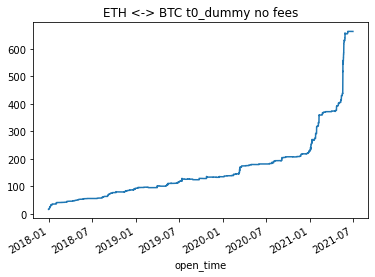

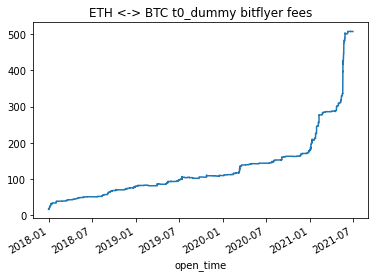

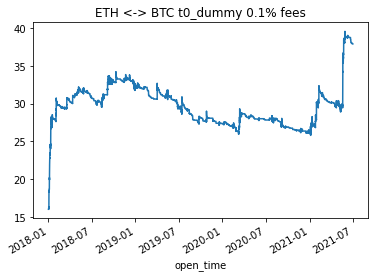

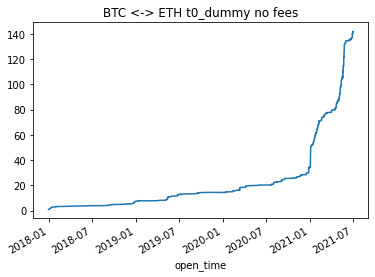

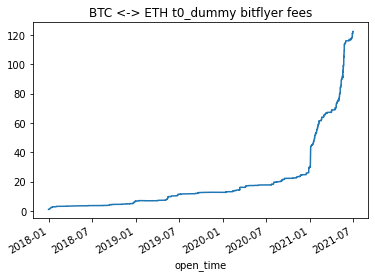

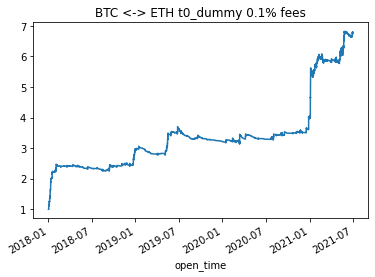

In [9]:
import matplotlib.pyplot as plt
for k,v in simulation_results.items():
    v[v['action']!='none'].to_csv(f'./results/{k}.csv')
    fig, ax = plt.subplots()
    ax.set_title(k)
    v.total_value.plot(figure=fig)